# Zhang, PD from HCA

- https://data.humancellatlas.org/explore/projects/9a23ac2d-93dd-4bac-9bb8-040e6426db9d

In [27]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad

In [28]:
opt_create_folder = True
if opt_create_folder:
    fs = glob.glob('/home/sonic/scData/HCA_PD_Zhang/GSE202210_RAW/*') 
    fs = list(set([f.split('/')[5].split('_')[1] for f in fs]))
    for f in fs:
        fs1 = glob.glob('/home/sonic/scData/HCA_PD_Zhang/GSE202210_RAW/*' + f + '*')
        os.system('rm -rf /home/sonic/scData/HCA_PD_Zhang/' + f)
        os.system('mkdir /home/sonic/scData/HCA_PD_Zhang/' + f)
        for f1 in fs1:
            if 'genes' in f1:
                cmd = ' '.join(['cp', f1, '/home/sonic/scData/HCA_PD_Zhang/' + f + '/features.tsv.gz'])
            else:
                cmd = ' '.join(['cp', f1, '/home/sonic/scData/HCA_PD_Zhang/' + f + '/' + f1.split('_')[-1]])
            os.system(cmd)
else:
    print ('Files are exist')

In [29]:
!ls /home/sonic/scData/HCA_PD_Zhang/

 GSE202210_RAW	     RAW					   hsDG197PD
 GSE202210_RAW.tar  'ZhangLabPdBrainNuclei 2023-03-17 01.45.tsv'   hsDG208PD
 HSDG07HC	     hsDG101HC					   hsDG30HC
 HSDG10HC	     hsDG13HC					   hsDG99HC
 HSDG148PD	     hsDG142PD
 HSDG199PD	     hsDG151PD


In [30]:
samples = ['HSDG07HC','HSDG10HC','hsDG101HC','hsDG13HC','hsDG30HC','hsDG99HC',
          'HSDG148PD','HSDG199PD','hsDG142PD','hsDG151PD','hsDG197PD','hsDG208PD']

In [31]:
list_data = []
for f in samples:
    adata1 = sc.read_10x_mtx('/home/sonic/scData/HCA_PD_Zhang/' + f)
    adata1.name = f
    adata1.obs['sampleID'] = f
    sc.pp.filter_cells(adata1, min_counts=50)
    adata1.obs_names = [f'{adata1.name}_{i}' for i in adata1.obs_names]
    list_data.append(adata1)

In [32]:
adata1.obs

,sampleID,n_counts
hsDG208PD_AAACCCAAGCGATGGT-1,hsDG208PD,771.0
hsDG208PD_AAACCCACAGGTGTGA-1,hsDG208PD,4846.0
hsDG208PD_AAACCCATCCATGATG-1,hsDG208PD,1411.0
hsDG208PD_AAACCCATCTTACTGT-1,hsDG208PD,7180.0
hsDG208PD_AAACGAACACAGAGCA-1,hsDG208PD,6147.0
...,...,...
hsDG208PD_TTTGTTGGTCGCGTCA-1,hsDG208PD,3555.0
hsDG208PD_TTTGTTGGTGAACGGT-1,hsDG208PD,12772.0
hsDG208PD_TTTGTTGGTGTTGATC-1,hsDG208PD,21701.0
hsDG208PD_TTTGTTGTCATCGGGC-1,hsDG208PD,4815.0


In [33]:
adata = ad.concat(list_data, join="outer")

In [34]:
adata

AnnData object with n_obs × n_vars = 77983 × 33538
    obs: 'sampleID', 'n_counts'

In [35]:
meta = pd.read_csv('/home/sonic/scData/HCA_PD_Zhang/ZhangLabPdBrainNuclei 2023-03-17 01.45.tsv', sep='\t')
meta.rename(columns={'library_preparation_protocol.library_construction_approach':'Assay', 
                     'donor_organism.biomaterial_core.biomaterial_id':'sampleID', 
                     'specimen_from_organism.organ_part':'Organ',
                     'donor_organism.sex':'Sex',
                     'specimen_from_organism.diseases':'Diagnosis',
                     'donor_organism.organism_age':'Age'}, inplace=True)

# Make a unique list for each sample
meta = meta[meta.read_index=='read1']

# Update information
meta['Brain_Region'] = 'BA9'
meta['batch'] = 'Unknown'
meta['Race'] = 'Unknown'
meta['PMI'] = 'Unknown'
meta['Stage'] = 'Adult'
meta['Dataset'] = 'ZhangPD'
# meta['Diagnosis'] = 'normal'
meta['Hemisphere'] = 'A'
meta['Library'] = 'snRNA'
meta['Assay'] = "10x Chromium 3' v3"
meta.loc[meta['Sex']=='female', 'Sex'] = 'F'
meta.loc[meta['Sex']=='male', 'Sex'] = 'M'
meta.loc[meta['Diagnosis']=='Parkinson disease', 'Diagnosis'] = 'PD'

# Subset
cols_to_use = ['batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library',
               'Brain_Region', 'Dataset', 'Sex', 'Diagnosis']
meta = meta[cols_to_use]
meta = meta.drop_duplicates()

# meta = meta.loc[meta.sampleID.str.contains('HC_')]
meta = meta.reset_index()
meta.sampleID = meta.sampleID.str.split('_').str[0]

In [36]:
meta.Diagnosis.value_counts()

normal    6
PD        6
Name: Diagnosis, dtype: int64

In [37]:
def calculate_age(age):
    if ' year' in age:
        # Extract the numeric part of the age string and convert it to an integer
        age_years = float(age.split(' year')[0].split('-')[0])
        # Multiply the age in years by 365 and add 365 to get the age in days
        age_days = age_years * 365 + 365
        age_days = int(age_days)
        return age_days
    elif 'ga' in age:
        # Extract the numeric part of the age string and convert it to an integer
        age_weeks = int(age.split('ga')[1])
        # Multiply the age in years by 365 and add 365 to get the age in days
        age_days = age_weeks * 7
        return age_days
    elif 'pcw' in age:
        # Extract the numeric part of the age string and convert it to an integer
        age_weeks = int(age.split('pcw')[1])
        # Multiply the age in years by 365 and add 365 to get the age in days
        age_days = age_weeks * 7
        return age_days
    else:
        # If the age string doesn't contain 'd' or 'y', return None
        return None

In [38]:
meta['Age'] = meta['Age'].apply(calculate_age)

In [39]:
meta

,index,batch,sampleID,Age,Assay,Stage,Race,PMI,Hemisphere,Library,Brain_Region,Dataset,Sex,Diagnosis
0,1,Unknown,hsDG13HC,24090,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
1,3,Unknown,HSDG07HC,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
2,6,Unknown,hsDG151PD,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD
3,9,Unknown,hsDG30HC,23360,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,M,normal
4,10,Unknown,hsDG101HC,26645,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
5,15,Unknown,HSDG10HC,25915,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,M,normal
6,19,Unknown,hsDG197PD,26645,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD
7,22,Unknown,hsDG142PD,29200,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,M,PD
8,25,Unknown,HSDG148PD,35405,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,M,PD
9,29,Unknown,hsDG99HC,25550,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,M,normal


In [40]:
adata.obs['x2'] = adata.obs.index
adata.obs = pd.merge(adata.obs, meta, on='sampleID', how='left')
adata.obs = adata.obs.set_index('x2')

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [41]:
adata.obs

,sampleID,n_counts,index,batch,Age,Assay,Stage,Race,PMI,Hemisphere,Library,Brain_Region,Dataset,Sex,Diagnosis
x2,,,,,,,,,,,,,,,
HSDG07HC_AAACCCAAGAATAACC-1,HSDG07HC,1800.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
HSDG07HC_AAACCCAAGTCATCCA-1,HSDG07HC,9864.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
HSDG07HC_AAACCCAGTAATCAGA-1,HSDG07HC,3808.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
HSDG07HC_AAACCCATCCATTCGC-1,HSDG07HC,9848.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
HSDG07HC_AAACGAAAGGAGTACC-1,HSDG07HC,28887.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsDG208PD_TTTGTTGGTCGCGTCA-1,hsDG208PD,3555.0,36,Unknown,28470,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD
hsDG208PD_TTTGTTGGTGAACGGT-1,hsDG208PD,12772.0,36,Unknown,28470,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD
hsDG208PD_TTTGTTGGTGTTGATC-1,hsDG208PD,21701.0,36,Unknown,28470,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD


In [42]:
# Barcode가 실제 작동하는지 확인하기 위해 UMAP
adata_int = adata.copy()
sc.pp.normalize_total(adata_int)
sc.pp.log1p(adata_int)

In [43]:
adata_int

AnnData object with n_obs × n_vars = 77983 × 33538
    obs: 'sampleID', 'n_counts', 'index', 'batch', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis'
    uns: 'log1p'

In [44]:
sc.pp.highly_variable_genes(adata_int, n_top_genes=2000)
sc.tl.pca(adata_int)
sc.pp.neighbors(adata_int, n_neighbors=10, n_pcs=50)

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
sc.tl.umap(adata_int)
sc.tl.leiden(adata_int, resolution=0.5)

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


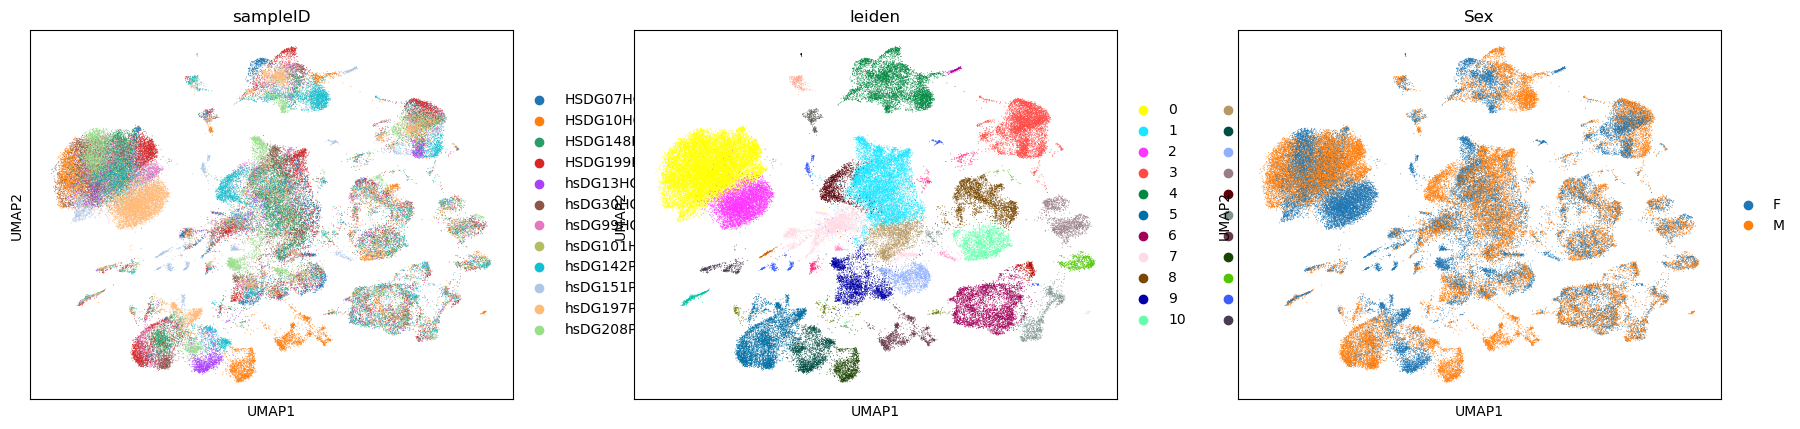

In [46]:
sc.pl.umap(adata_int, color=['sampleID', 'leiden', 'Sex'])

# Annotation using reference data (Healthy brains from Morabito 2021)

In [47]:
adata_ref = sc.read_h5ad('/home/sonic/scData/anndata/Morabito2021.h5ad')

In [48]:
sc.pp.normalize_total(adata_ref)
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(adata_ref, n_top_genes=2000)
sc.tl.pca(adata_ref)
sc.pp.neighbors(adata_ref, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_ref)
sc.tl.leiden(adata_ref, resolution=0.5)

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


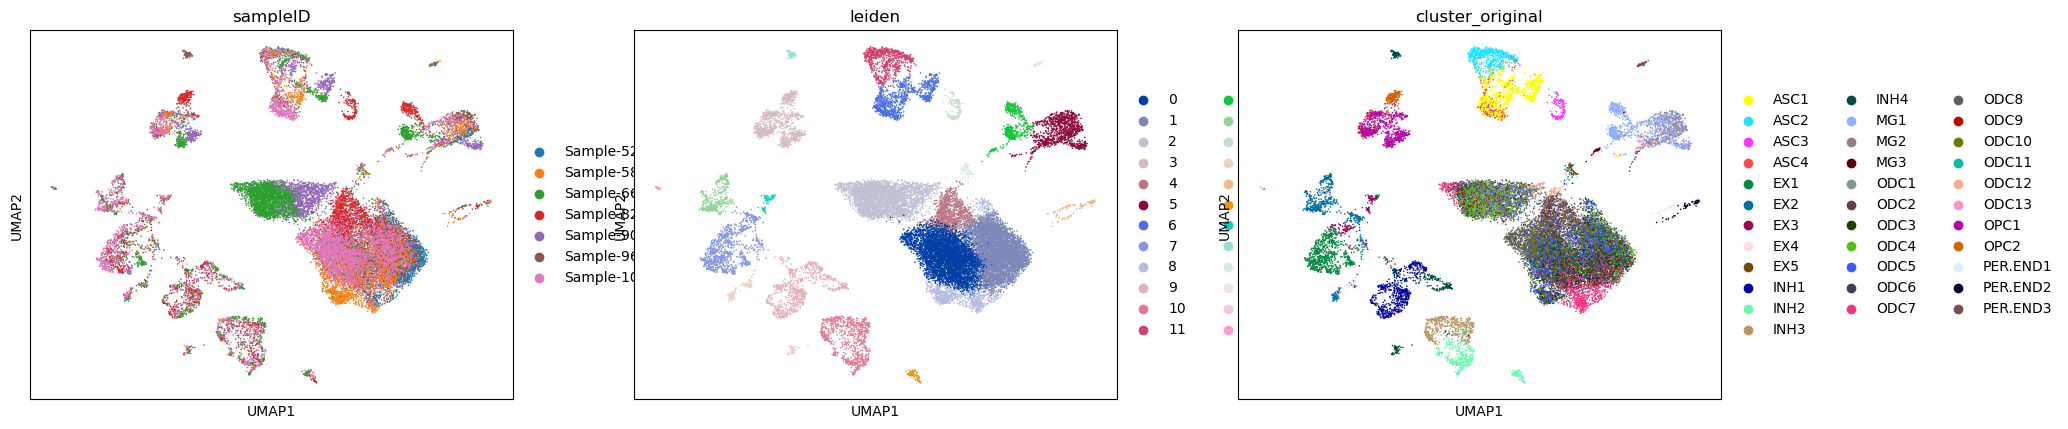

In [49]:
sc.pl.umap(adata_ref, color=['sampleID', 'leiden', 'cluster_original'])

In [50]:
var_names = adata_ref.var_names.intersection(adata_int.var_names)
adata_ref = adata_ref[:, var_names]
adata_int = adata_int[:, var_names]

In [51]:
sc.tl.ingest(adata_int, adata_ref, obs='cluster_original')

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


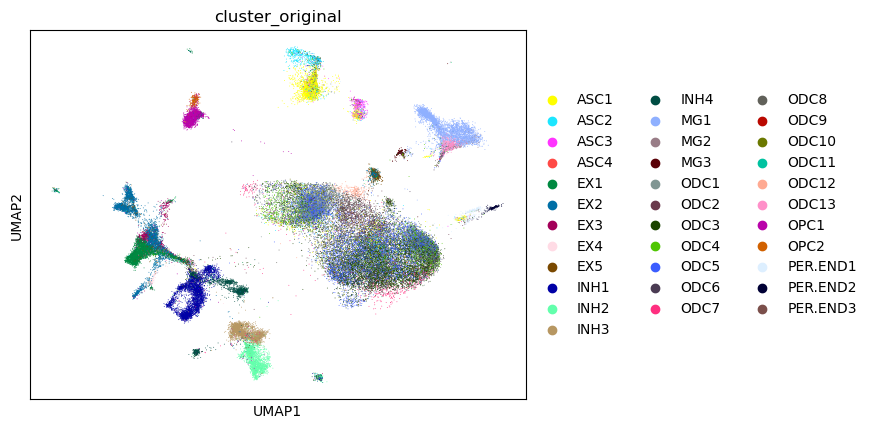

In [52]:
sc.pl.umap(adata_int, color=['cluster_original'], wspace=0.5)

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


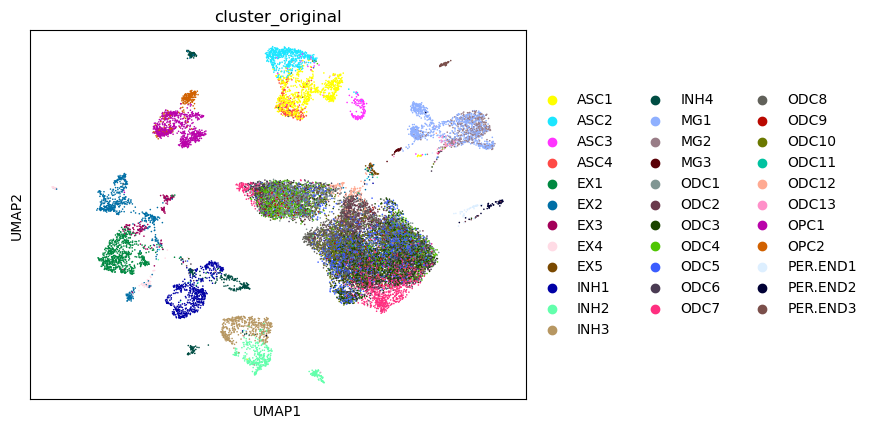

In [53]:
sc.pl.umap(adata_ref, color=['cluster_original'], wspace=0.5)

In [54]:
# Update the cell type
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('EX'), 'cluster_main'] = 'Ext'
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('INH'), 'cluster_main'] = 'IN'
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('MG'), 'cluster_main'] = 'MG'
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('ASC'), 'cluster_main'] = 'Astro'
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('ODC'), 'cluster_main'] = 'OD'
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('OPC'), 'cluster_main'] = 'OPC'
adata_int.obs.loc[adata_int.obs['cluster_original'].str.contains('PER.END'), 'cluster_main'] = 'Others'

/home/sonic/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


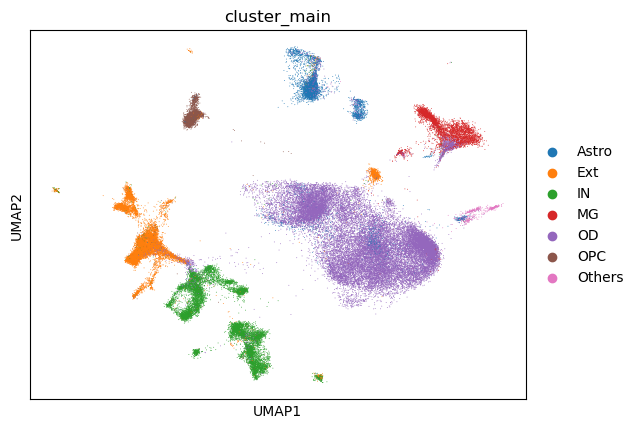

In [55]:
sc.pl.umap(adata_int, color=['cluster_main'], wspace=0.5)

In [56]:
sum(adata.obs.index == adata_int.obs.index)

77983

In [57]:
# Update the cluster names
adata.obs = adata_int.obs

In [58]:
adata.write('/home/sonic/scData/anndata/HCA_ZhangPD.h5ad')

In [59]:
adata.obs

,sampleID,n_counts,index,batch,Age,Assay,Stage,Race,PMI,Hemisphere,Library,Brain_Region,Dataset,Sex,Diagnosis,leiden,cluster_original,cluster_main
x2,,,,,,,,,,,,,,,,,,
HSDG07HC_AAACCCAAGAATAACC-1,HSDG07HC,1800.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal,21,PER.END1,Others
HSDG07HC_AAACCCAAGTCATCCA-1,HSDG07HC,9864.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal,1,EX1,Ext
HSDG07HC_AAACCCAGTAATCAGA-1,HSDG07HC,3808.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal,6,INH1,IN
HSDG07HC_AAACCCATCCATTCGC-1,HSDG07HC,9848.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal,9,EX2,Ext
HSDG07HC_AAACGAAAGGAGTACC-1,HSDG07HC,28887.0,3,Unknown,29930,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,normal,13,EX2,Ext
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsDG208PD_TTTGTTGGTCGCGTCA-1,hsDG208PD,3555.0,36,Unknown,28470,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD,10,INH2,IN
hsDG208PD_TTTGTTGGTGAACGGT-1,hsDG208PD,12772.0,36,Unknown,28470,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD,3,OPC1,OPC
hsDG208PD_TTTGTTGGTGTTGATC-1,hsDG208PD,21701.0,36,Unknown,28470,10x Chromium 3' v3,Adult,Unknown,Unknown,A,snRNA,BA9,ZhangPD,F,PD,6,INH1,IN
